# Network Intrusion Detection Using Autoencoders

The aim of this project is to develop an **intrusion detection system** using neural networks, specifically **autoencoders**. Autoencoders are a type of neural network designed to encode and decode data, learning to reconstruct inputs by understanding their patterns. They are composed by two parts, the **Encoder** and the **Decoder** :

- Encoder: Compresses the input into a lower-dimensional representation.
- Decoder: Reconstructs the original input from the compressed representation.

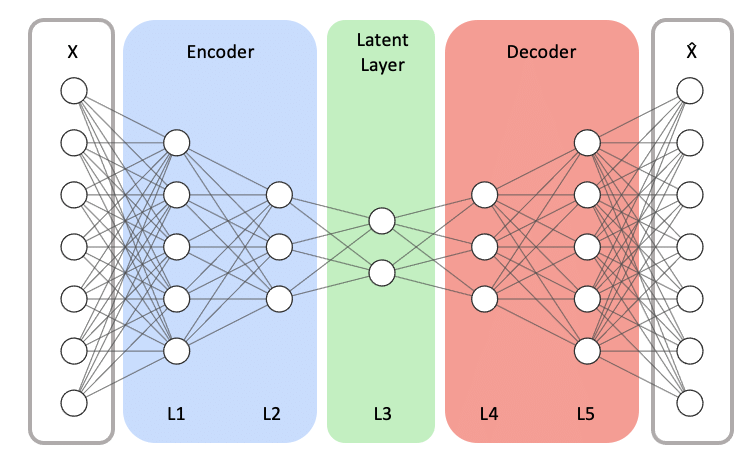

---


The main idea is to train the autoencoder only on genuine (normal) network traffic enabling it to understand the characteristics of non-anomalous data. During inference, test samples are passed through the network, and their **reconstruction error** is measured. If the error is greater than a predefined **threshold** (tuned as a hyperparameter), the sample is classified as anomalous, indicating a potential intrusion.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import keras
from tensorflow.keras import layers, losses, activations, initializers, regularizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, fbeta_score
from scikeras.wrappers import KerasRegressor

The project uses the data taken from the `NSL-KDD` dataset, which contains labeled data traffic towards network infrastucture.

# Data Insights
As a first step, we will use the `info()` method to inspect the dataset, identifying the number of features it contains along with their data types.

In [2]:
traffic_df = pd.read_csv('KDDTrainClean.csv') #load the dataset

#First look at the data
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

The dataset has three categorical columns (excluding the target label), while the rest are numeric. The last few columns are of type **float64** and, based on their names, probably represent percentage values.

In [3]:
traffic_df.head() #Visualize the top 5 samples of the dataset, to have a first idea about the features' values

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Using the `describe()` method, we can gather additional information about the features, such as the mean, standard deviation, and percentiles.

In [4]:
#Get some additional infos about the features in the datasets
traffic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


After this step, we observe that the feature `num_outbound_cmds` contains only zeros. Since it doesn't provide any useful information for the model, it makes sense to remove it from the dataset.

In [5]:
traffic_df.drop("num_outbound_cmds", axis=1, inplace=True)

# Data Visualization

Now, it's time to better visualize the features. We start by plotting an histogram for each numeric feature, in order to better understand their distribution.

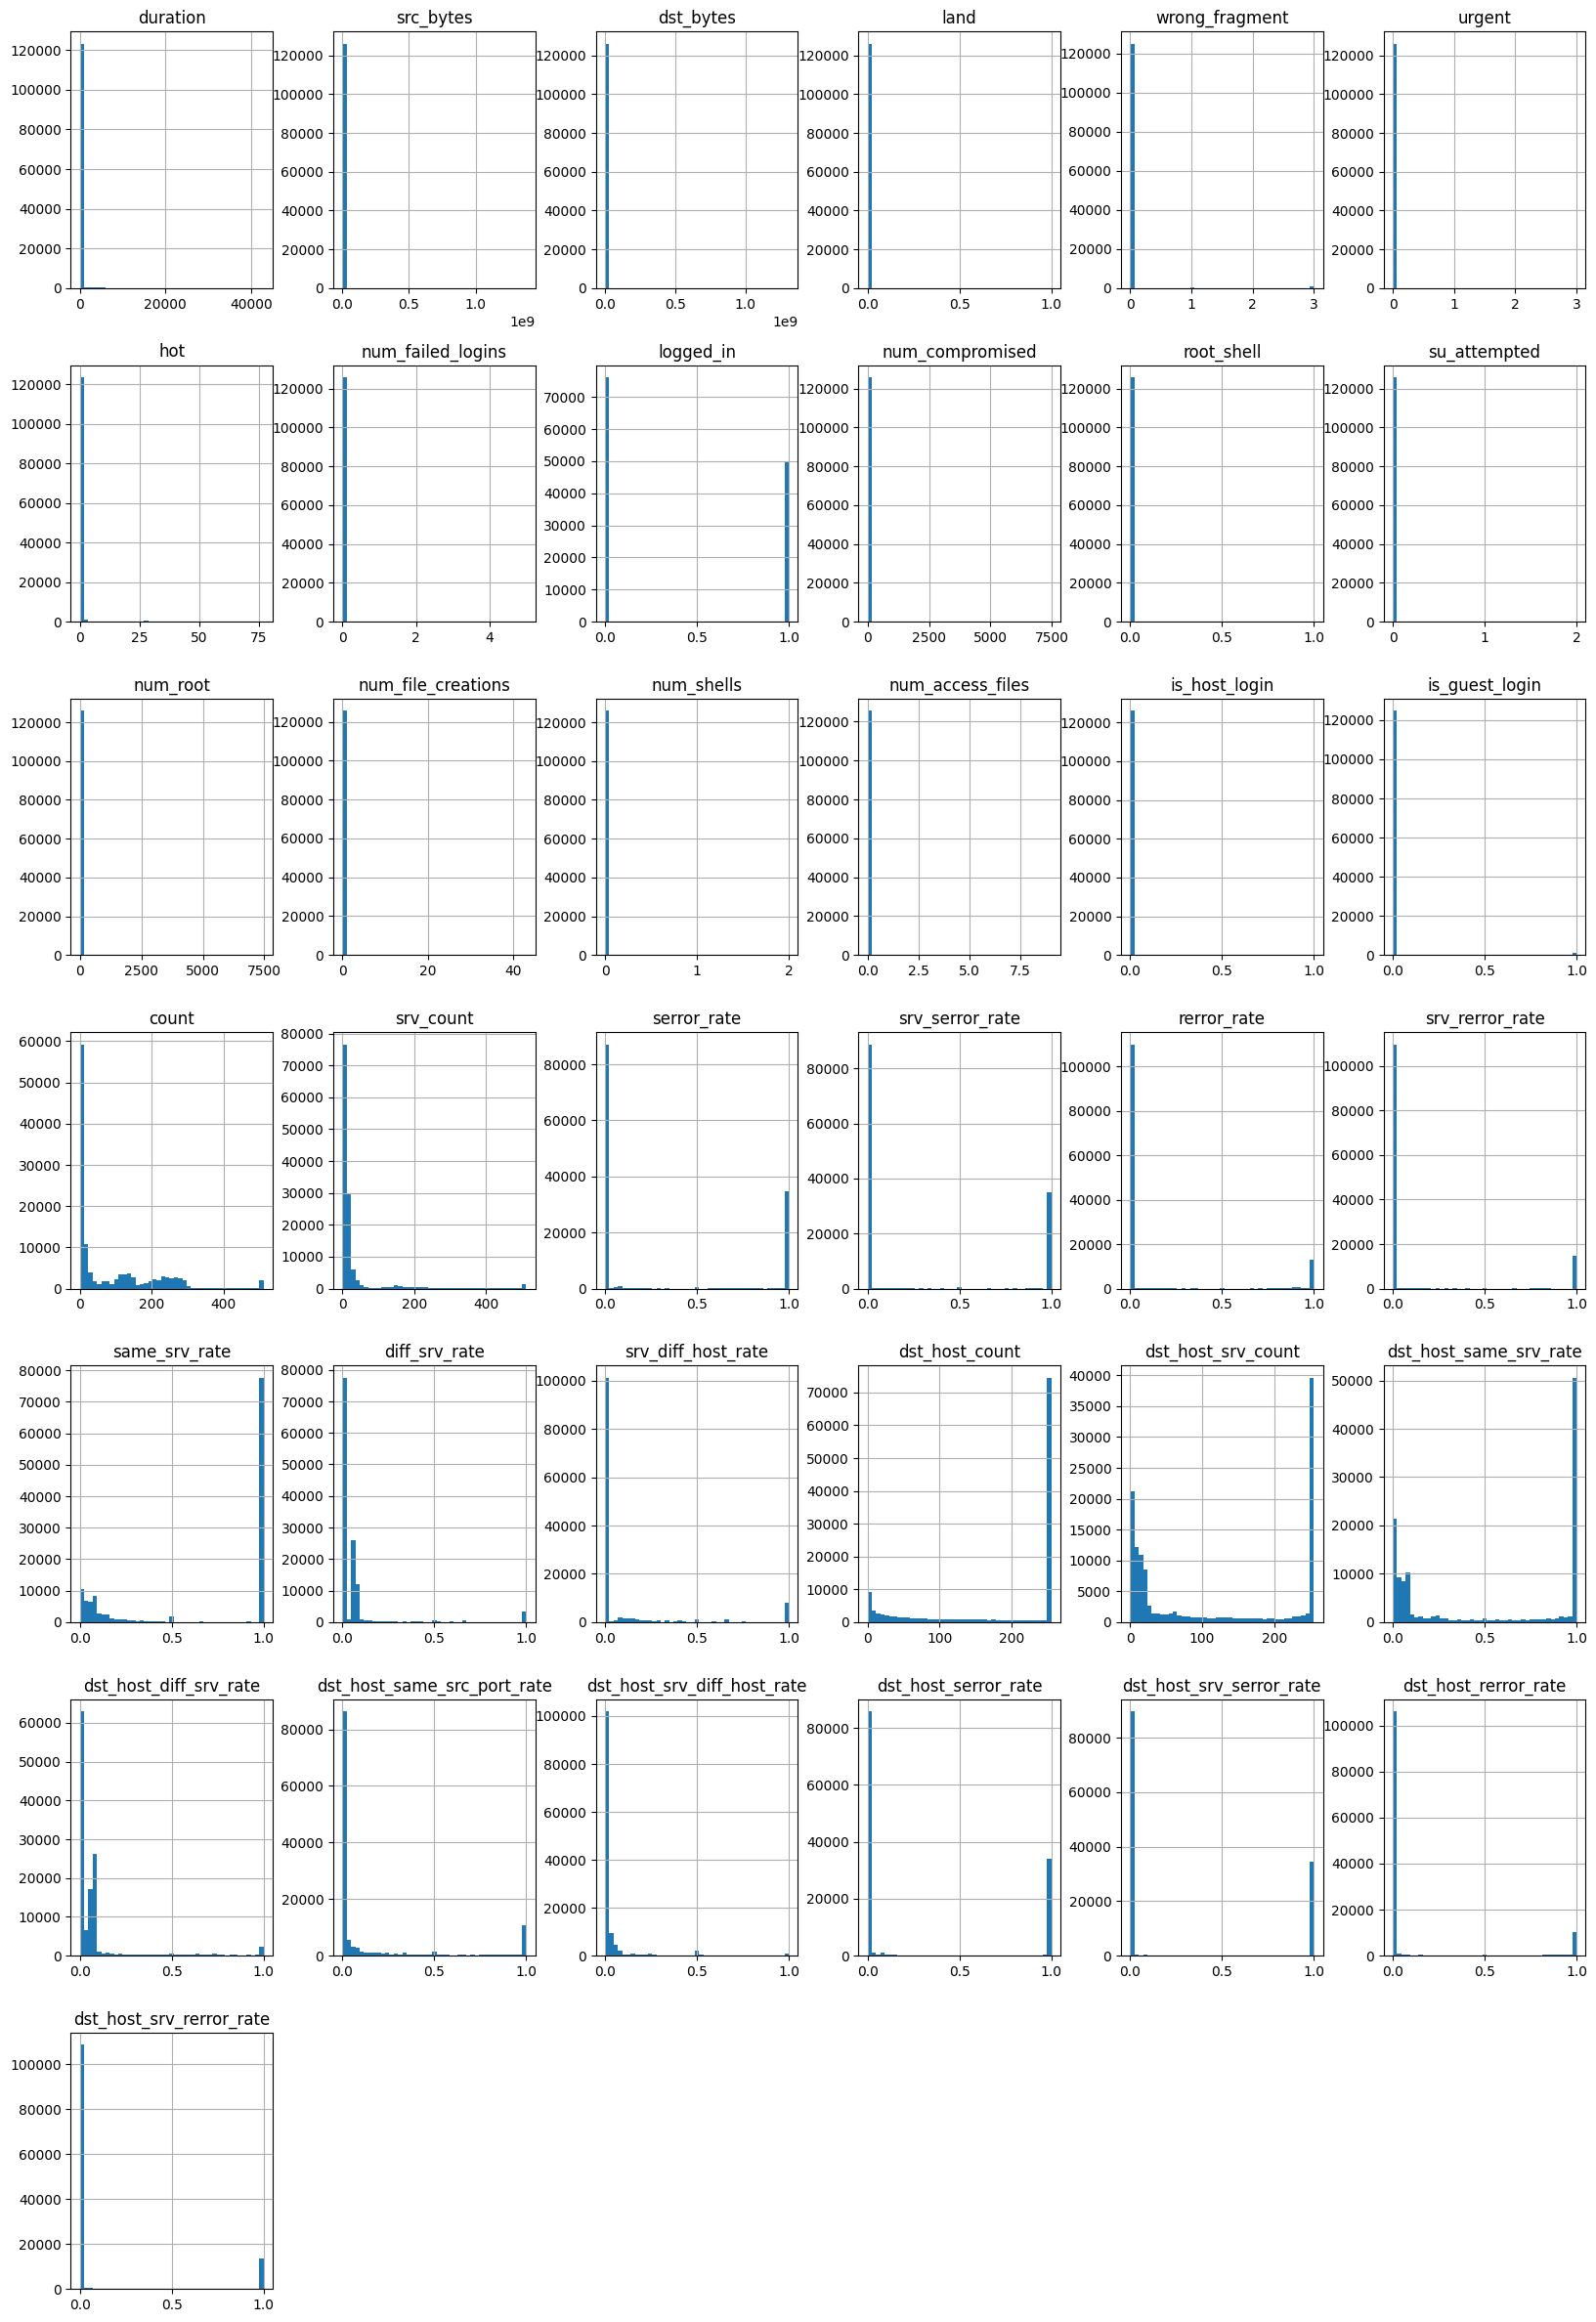

In [6]:
traffic_df.hist(bins=43,figsize=(20,30));

Features' visualization gave us some informations about the dataset, we can see that the majority of features appear to contain mostly zeros, while some shows a heavy-tailed distribution. A more detailed examination of them will be done during the outlier analysis phase. 

---
 Let's also have a look at categorical features' distribution.

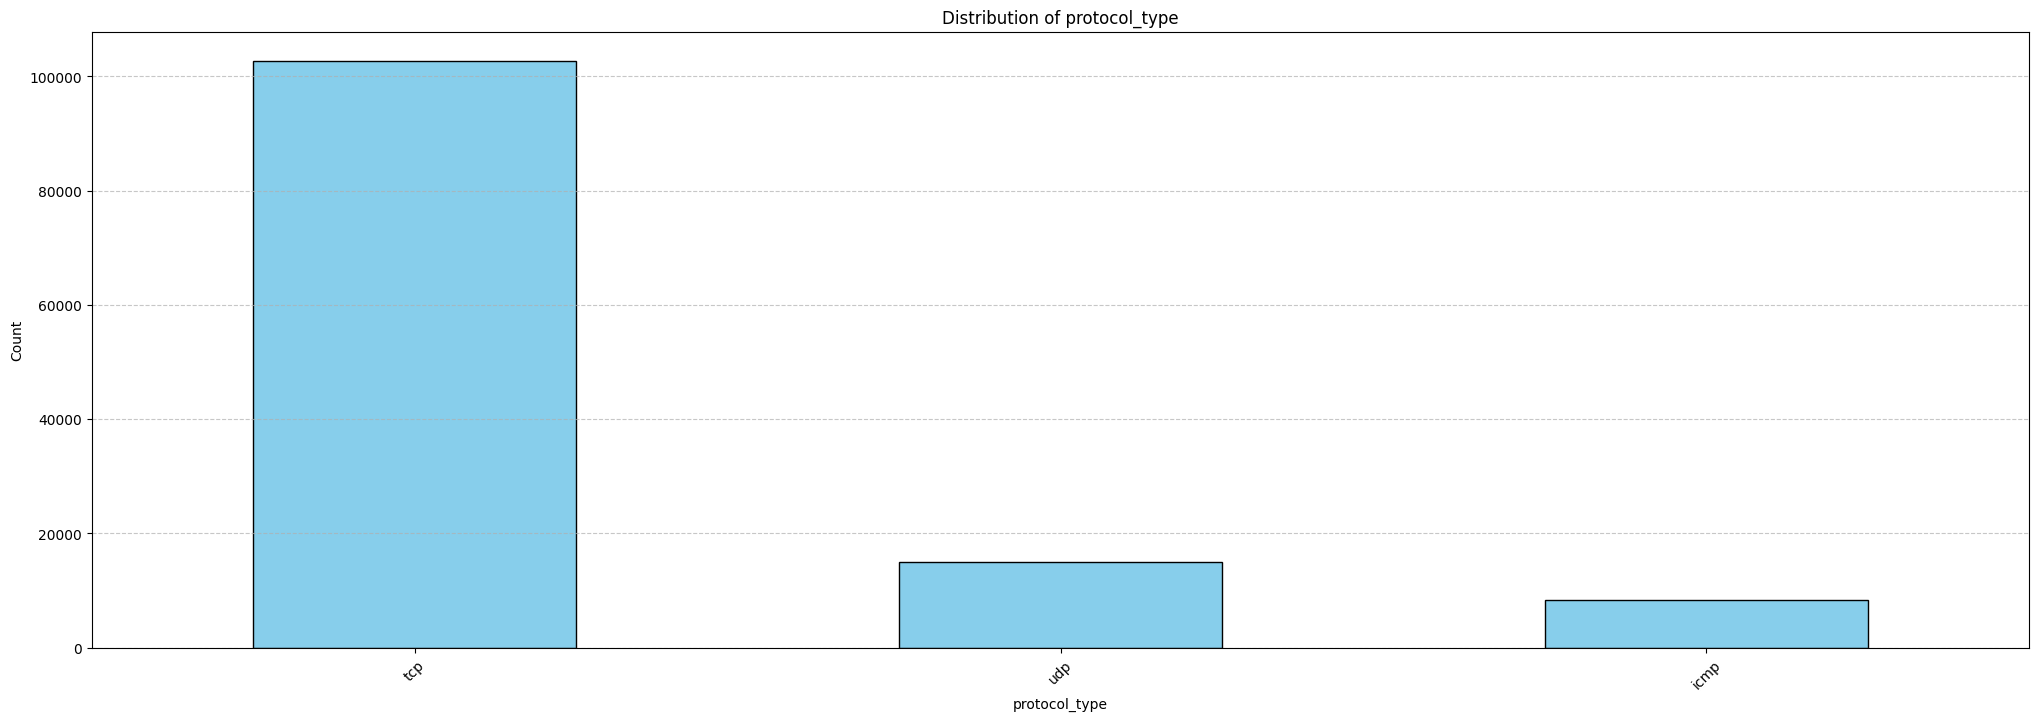

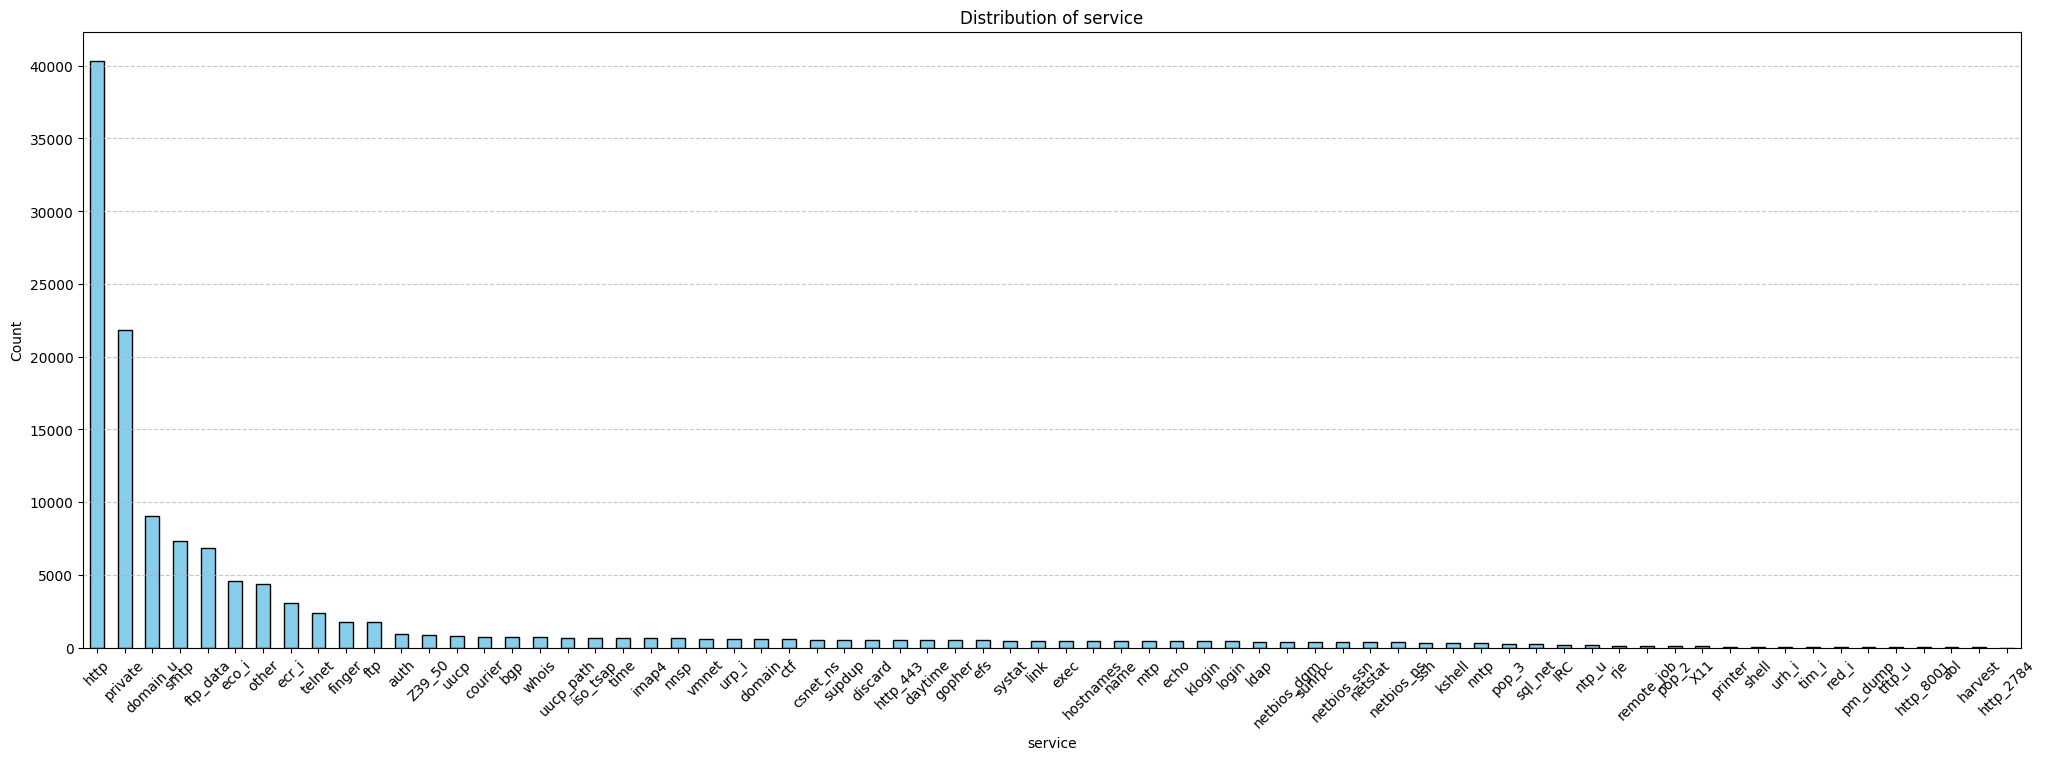

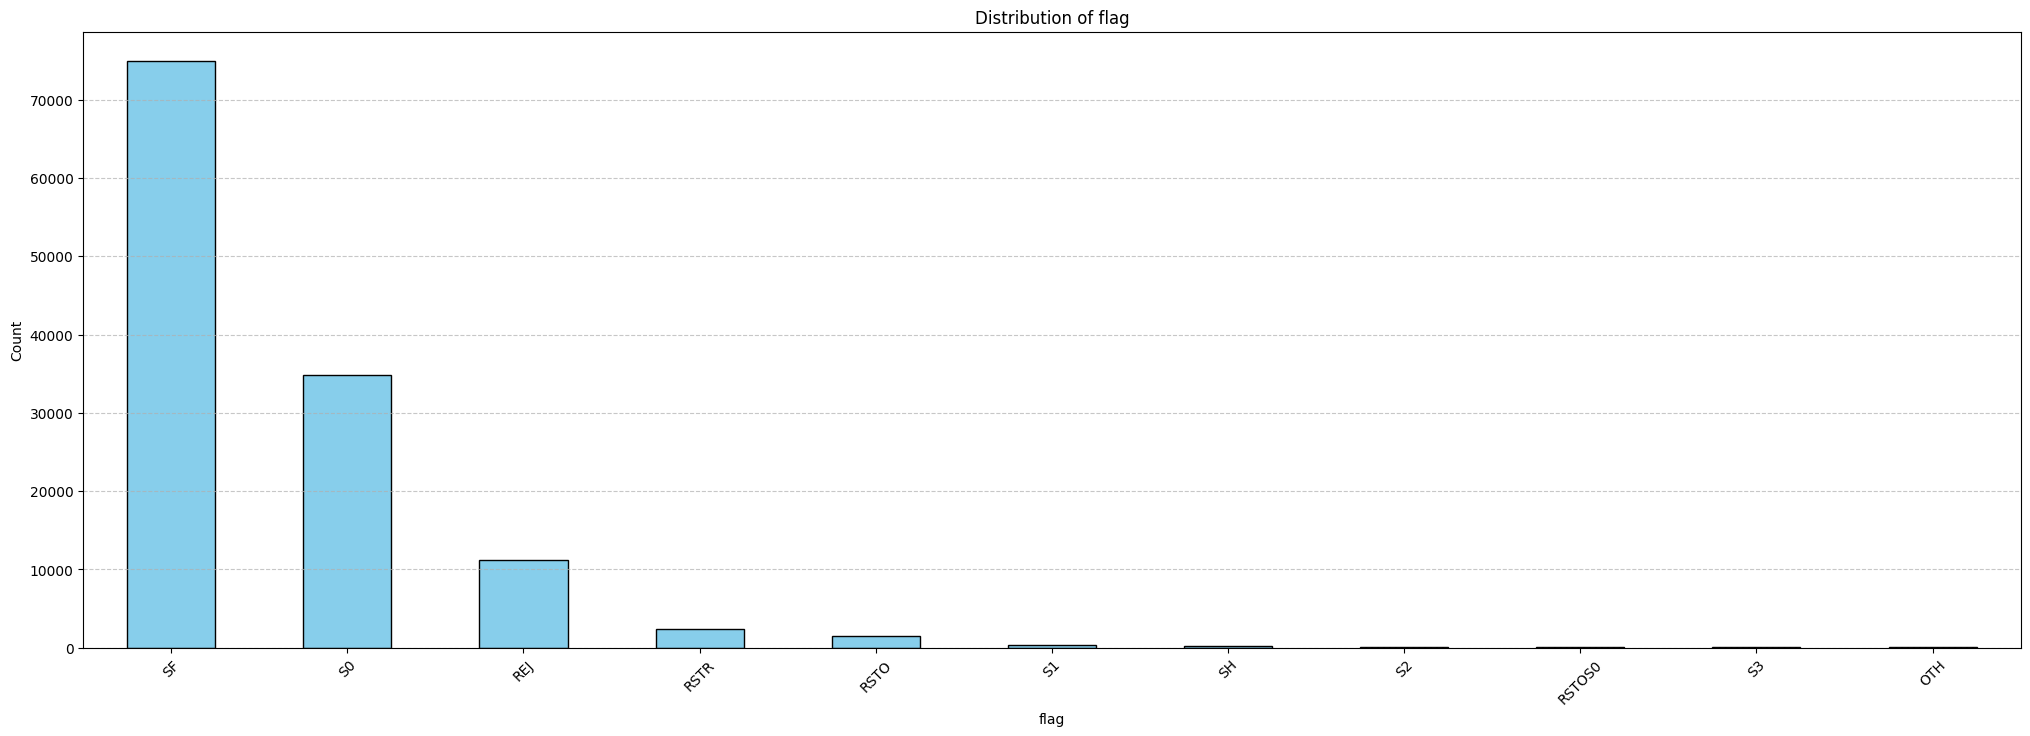

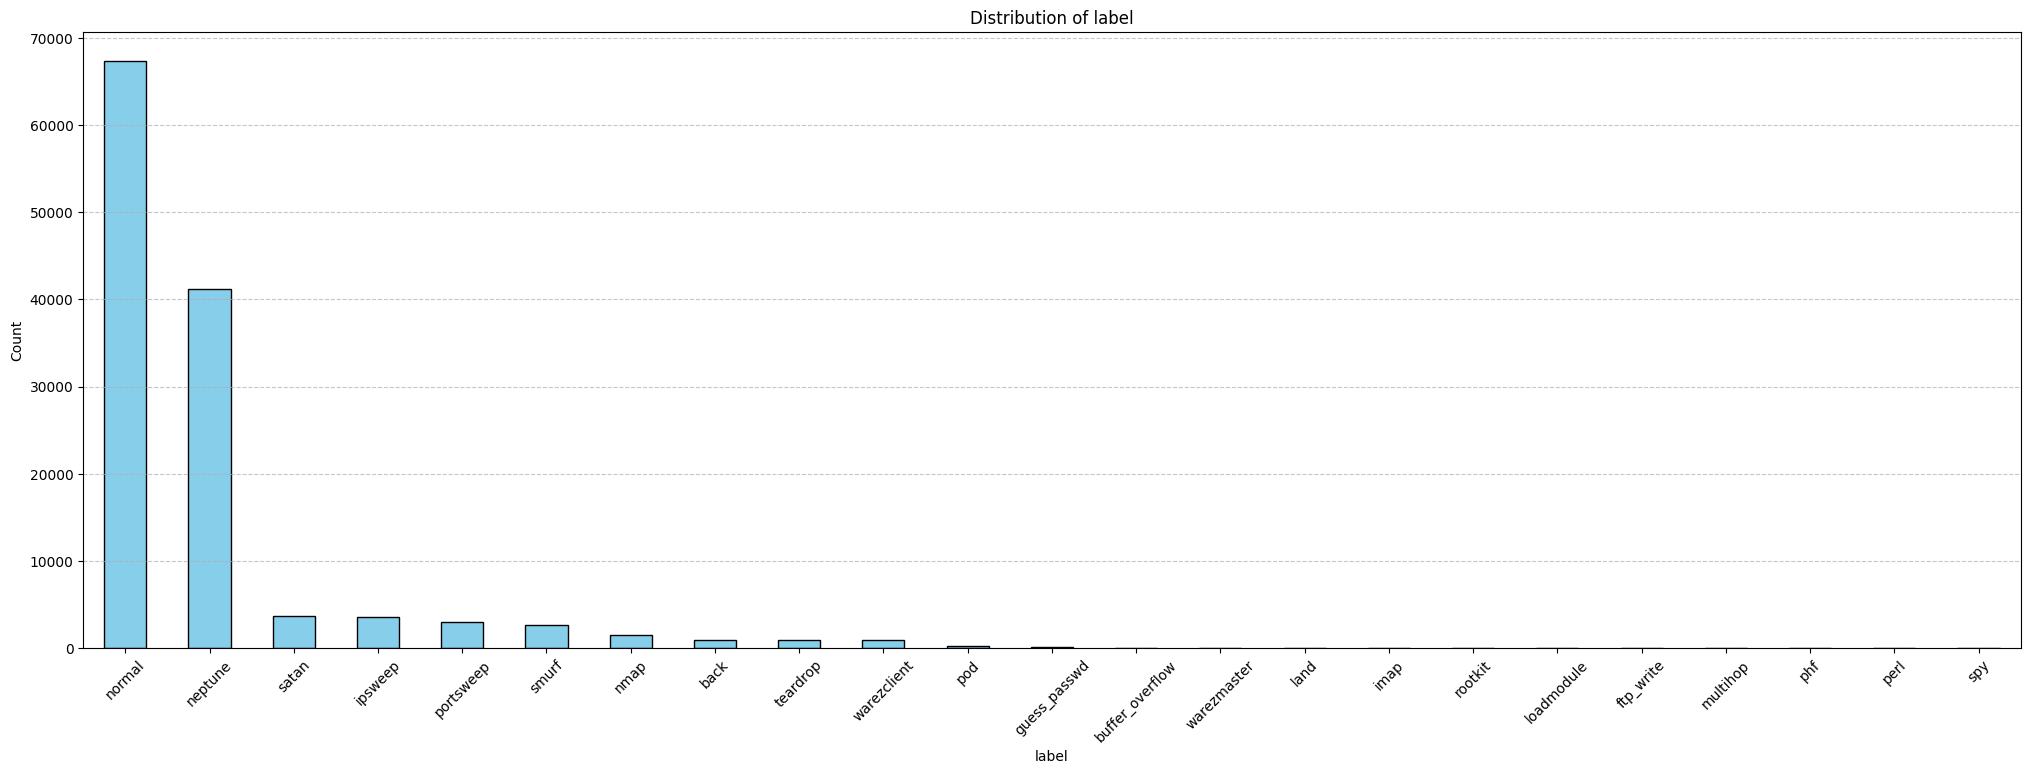

In [7]:
categorical_columns = traffic_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    plt.figure(figsize=(25, 8))
    traffic_df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Data cleaning

Data cleaning is an important step in creating a machine learning project, this ensure that the dataset is suitable for analysis. This process involves identifying and handling missing values, removing duplicates, and detecting (and in case handling) outliers.

While missing and duplicated values are cleaned in the complete dataset, the outlier phase will focus only on the training data.

## Searching for missing values

In [6]:
total = len(traffic_df)
missing_columns = traffic_df.columns[traffic_df.isnull().any()]

for col in missing_columns:
    null_count = traffic_df[col].isnull().sum()
    per = (null_count / total) * 100
    print(f"{col}: {null_count} ({per:.3f}%)")

No values are missing.

## Searching for duplicated samples

In [7]:
print(f"Number of duplicate rows: {traffic_df.duplicated().sum()}")

Number of duplicate rows: 0


We also don't have duplicated rows in the dataset.

# Splitting the dataset

It is essential to split the dataset early in the project to prevent data leakage. In particular, the test set must remain untouched until the final evaluation phase to ensure an unbiased model's performance. Before performing the split, verify that both the training and test sets are free from duplicate entries and missing values to maintain data integrity and consistency. Since we already did  these checks, we are ready to proceed with the split.

In [193]:
train_set, test_set = train_test_split(traffic_df, test_size = 0.2, random_state = 42, stratify = traffic_df['label'])

In [194]:
X_train, threshold_val = train_test_split(train_set, test_size = 0.2, random_state = 42, stratify = train_set['label']) #threshold_val is used for threshold tuning, after the model training

In [195]:
X_train.label = X_train.label.apply(lambda x:0 if x=='normal' else 1)
normal_data = X_train[X_train['label'] == 0].drop(columns = ['label'])

`normal_data` consists only of positive values and does not contain labels, as our objective is only to minimize the difference between the input and its reconstruction. Since the model learns patterns from the input data without predefined labels, training happens in an unsupervised manner.

In [196]:
test_set.label = test_set.label.apply(lambda x:0 if x=='normal' else 1)
threshold_val.label = threshold_val.label.apply(lambda x:0 if x=='normal' else 1)

X_test = test_set.drop(columns=['label'])
y_test = test_set['label']

X_thresh = threshold_val.drop(columns = ['label'])
y_thresh = threshold_val['label']

We still have some unused data, specifically, anomalies that weren’t included in the test or validation set. Our plan is to add some of these anomalies to the validation and test set, to balance them, if needed. The unused ones will be used at the end of the project, to see how the model will behave on detecting unseen anomalies.

In [197]:
anomalous_data = X_train[X_train['label'] == 1]
anomalous_X = anomalous_data.drop(columns = ['label'])
anomalous_y = anomalous_data['label']

In [198]:
anomalous_X.shape

(37523, 40)

In [199]:
num_normals_val = np.sum(y_thresh == 0)
num_anomalies_val = np.sum(y_thresh == 1)

num_normals_test = np.sum(y_test == 0)
num_anomalies_test = np.sum(y_test == 1)

# Print ratios
print(f"Validation Set - Normal: {num_normals_val}, Anomalies: {num_anomalies_val}")
print(f"Test Set - Normal: {num_normals_test}, Anomalies: {num_anomalies_test}")


Validation Set - Normal: 10775, Anomalies: 9381
Test Set - Normal: 13469, Anomalies: 11726


The final plan is to add 2,000 anomalies to test set and 1000 to validation set. The remaining ones will remain untouched.


In [200]:
X_anomalous_val = anomalous_X.iloc[:1000] 
y_anomalous_val = anomalous_y.iloc[:1000]

X_anomalous_test = anomalous_X.iloc[1000:3000]
y_anomalous_test = anomalous_y.iloc[1000:3000]

X_thresh = pd.concat([X_thresh, X_anomalous_val], axis=0)
y_thresh = pd.concat([y_thresh, y_anomalous_val], axis=0)

X_test = pd.concat([X_test, X_anomalous_test], axis=0)
y_test = pd.concat([y_test, y_anomalous_test], axis=0)

In [201]:
remaining_anomalies_X = anomalous_X.iloc[3000:]
remaining_anomalies_y = anomalous_y.iloc[3000:]

In [202]:
normal_data.shape, X_test.shape, X_thresh.shape

((43099, 40), (27195, 40), (21156, 40))

# Outliers detection and handling

Outliers are data points in the features that significantly deviate from the mean or typical range of values. They can occurr due to errors in data collection or can represent rare events. Outliers can alter the model's learning process, leading to wrong conclusions or biased model performance. So, it is important to identify and handle them. However, not every extreme value should be classified as an outlier, as some values may still be valid and within acceptable ranges. Said so, it is necessary to perform an analysis on these data points.
Since we aim to train the model only on genuine data, we will focus on identifying and handling them only in the training set `X_train`.

---



We will use boxplots to identify outliers in our dataset. The figure below illustrates how outliers are detected using this technique. Boxplots visually represent the distribution of data and highlight potential outliers based on the interquartile range (IQR). Any data points that fall below the lower bound (Q1 - 1.5 * IQR) or above the upper bound (Q3 + 1.5 * IQR) are considered outliers.
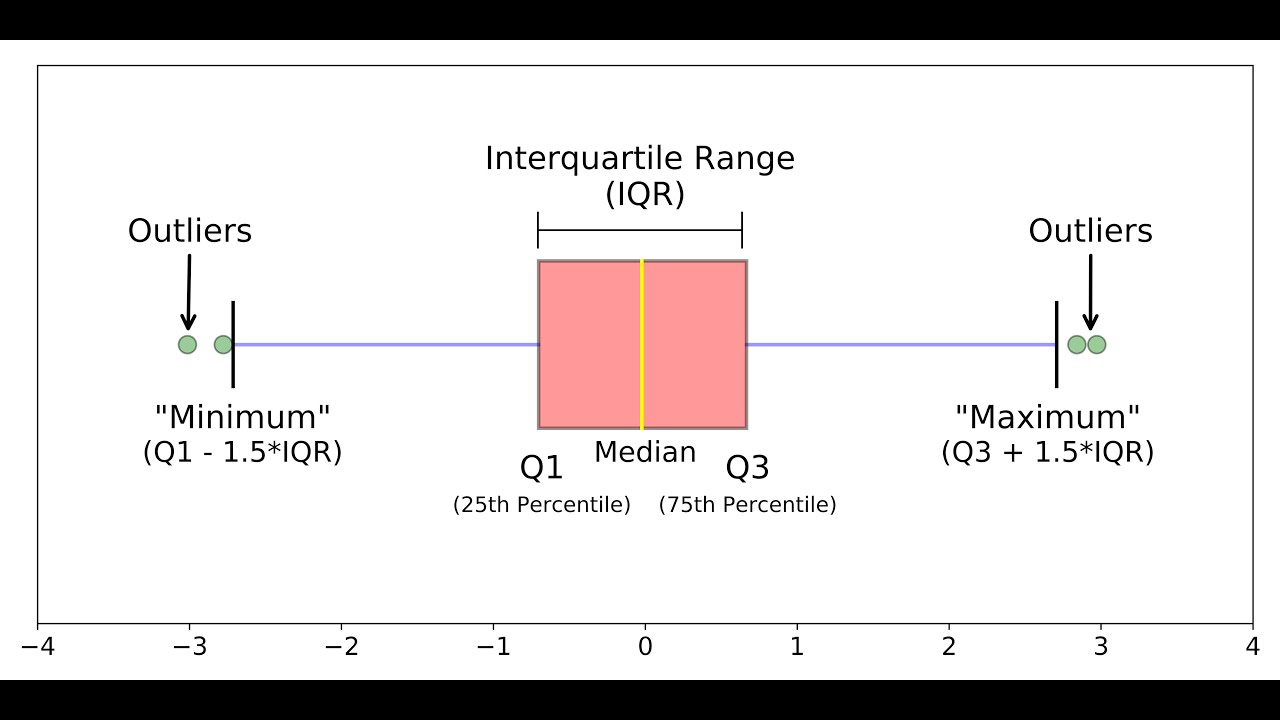

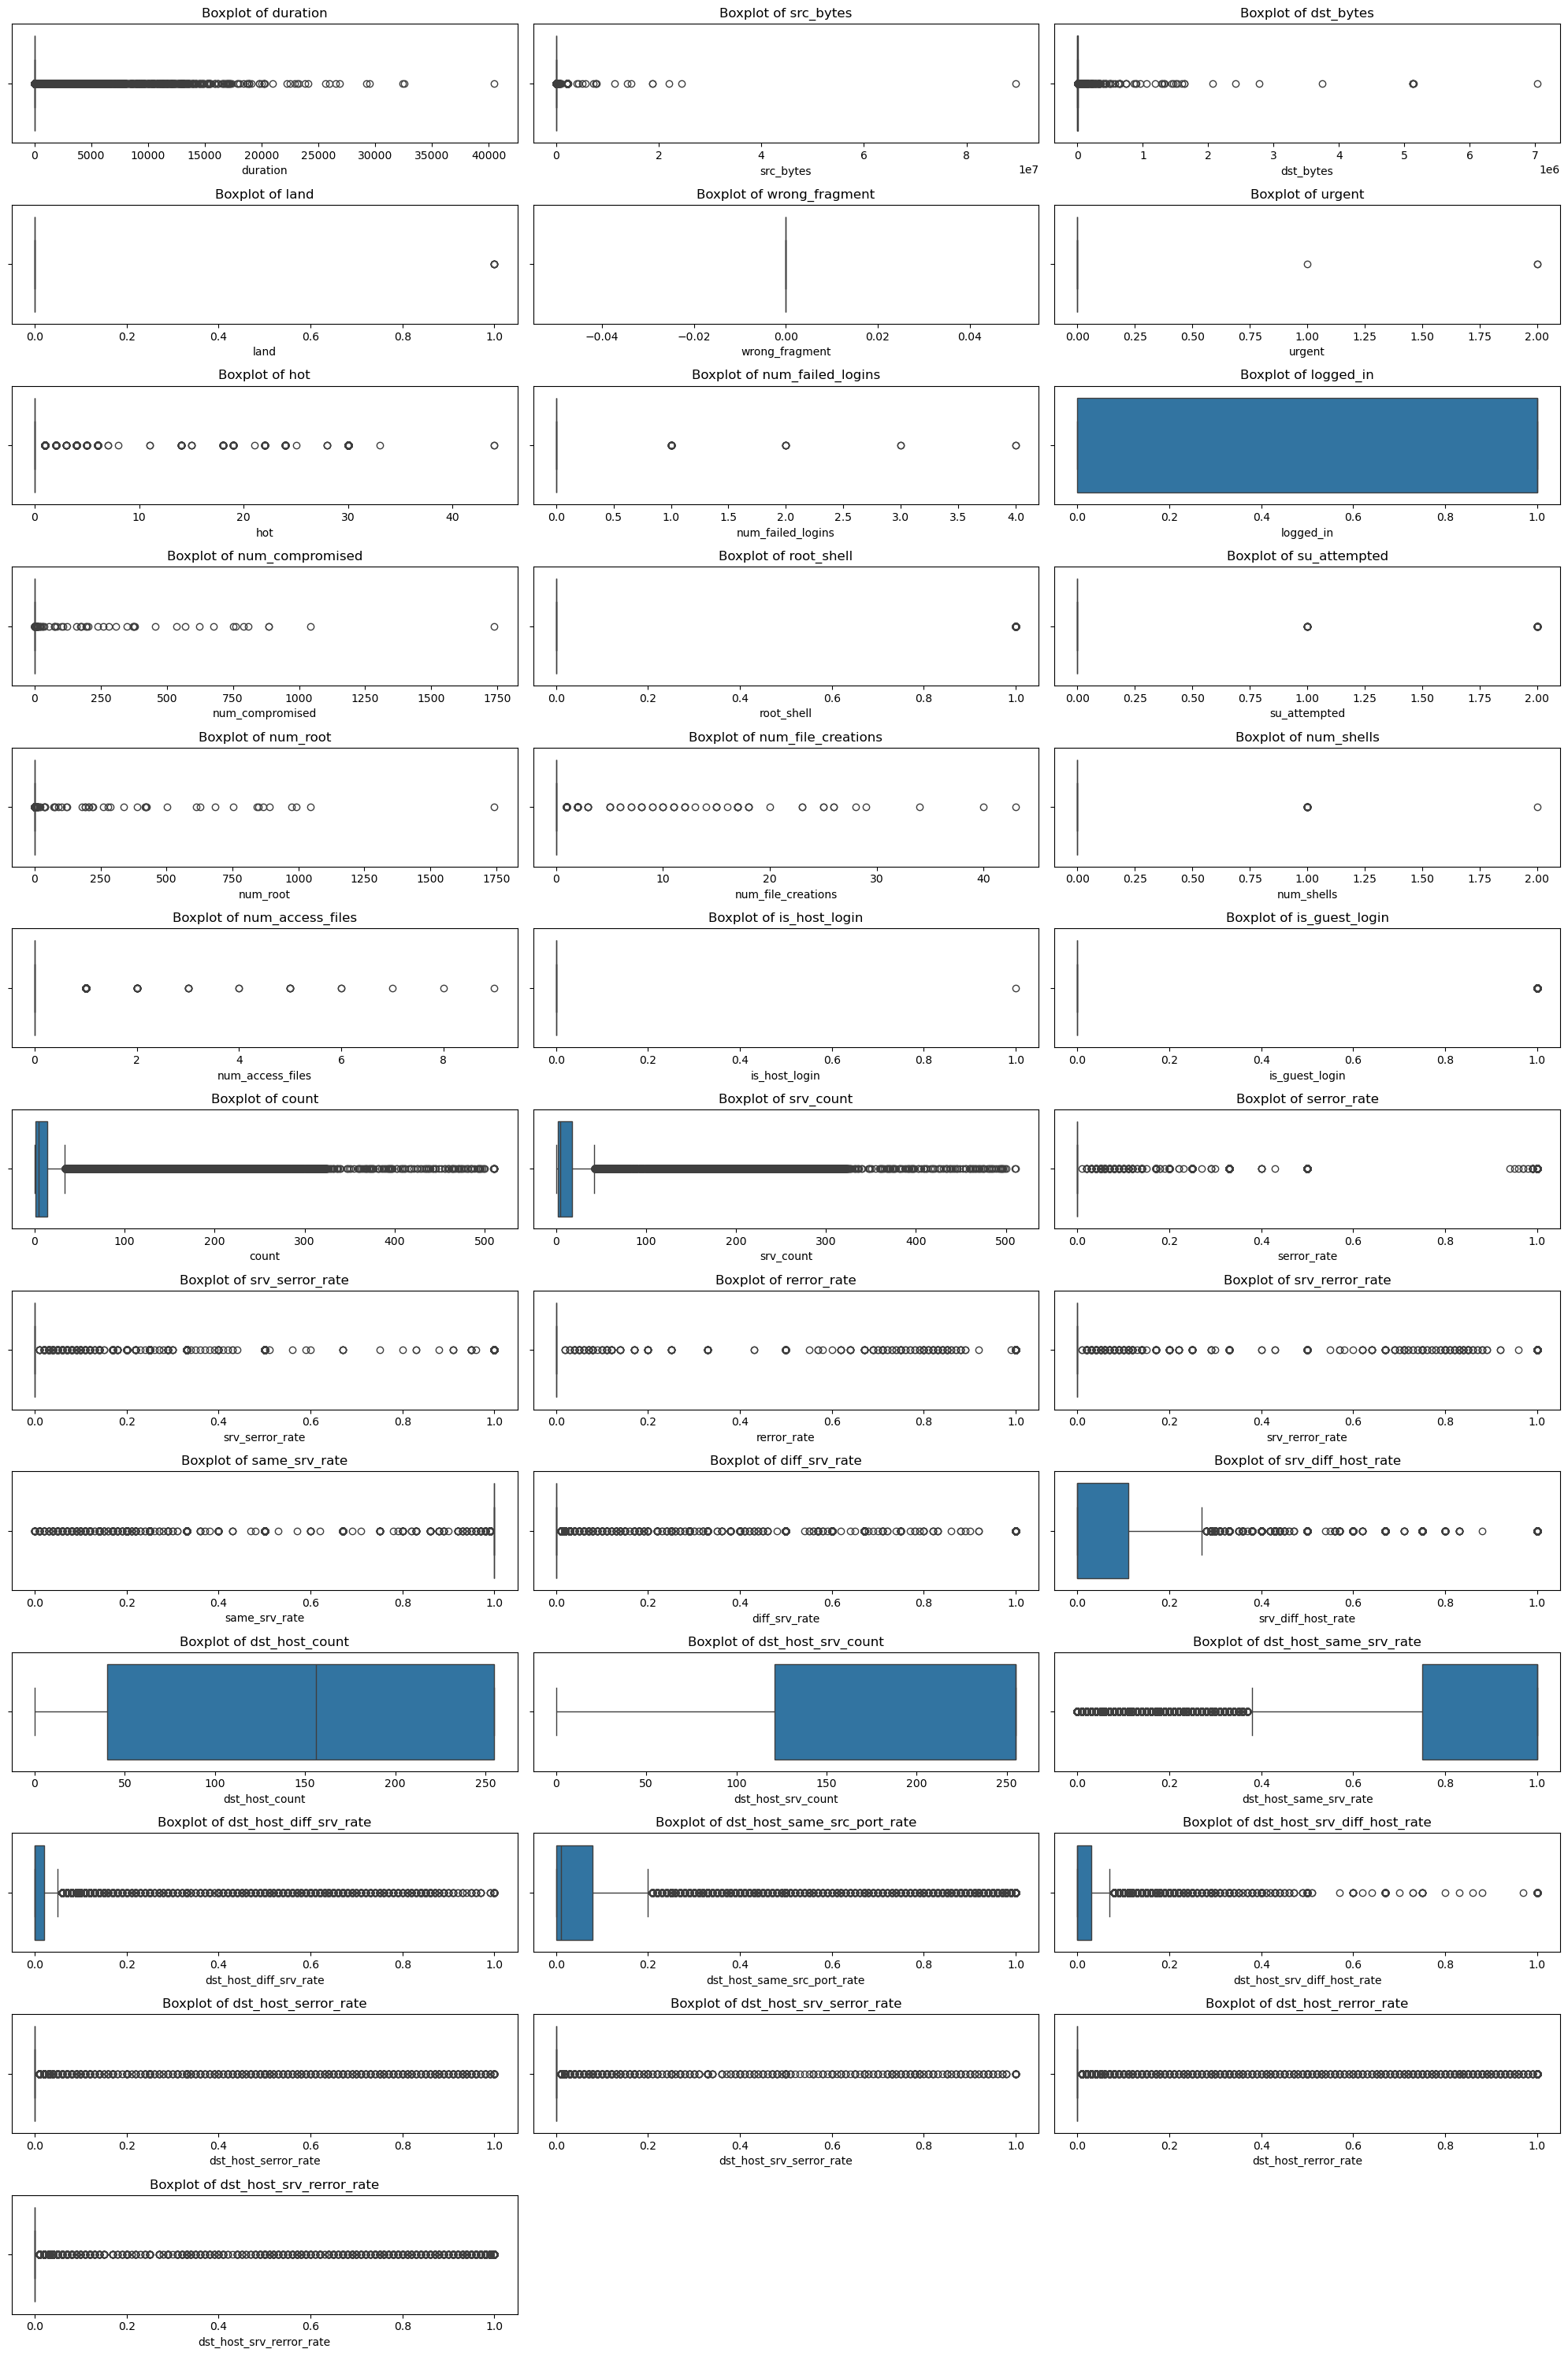

In [42]:
numeric_cols = [col for col in normal_data.columns if normal_data[col].dtype in ['int64', 'float64']]

num_cols = len(numeric_cols)
cols = 3
rows = (num_cols // cols) + (num_cols % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=normal_data[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Most of the numeric features in the dataset have **first quartile (Q1)** and **third quartile (Q3)** values equal to zero. Consequently, applying the boxplot technique for outlier detection would classify a large portion of the data as outliers. This makes it difficult to distinguish genuine outliers without additional context about the features and their distributions.

Given this, the final decision is to trim only the values that are significantly distant from the rest. Specifically, the features `src_bytes`, `duration`, `num_root`, and `num_compromised` contain a few extreme samples that stand out considerably. So, these features will be removed to improve the dataset's overall integrity.

In [313]:
normal_data = normal_data[normal_data['duration'] < 35000]
normal_data = normal_data[normal_data['src_bytes'] < 4e7]
normal_data = normal_data[normal_data['num_root'] < 1250]
normal_data = normal_data[normal_data['num_compromised'] < 1250]

In [314]:
normal_data.shape

(43096, 40)

Only three samples has been removed from the set.

# Data Preprocessing

The final step before building the model is data preprocessing, which prepares raw data for machine learning. This step ensures the data is in the right format for analysis and improves model performance by handling issues like unscaled features.
Numerical features are scaled using **MinMaxScaler** to map values between 0 and 1, while categorical features are transformed using **OneHotEncoder**, converting them into a binary matrix suitable for the model. To apply the right transformations to each feature type, **ColumnTransformer** is used.

In [210]:
categorical_columns = normal_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = normal_data.select_dtypes(include=['number']).columns.tolist()

In [211]:
num_pipeline = Pipeline([
  ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
  ('scaler', OneHotEncoder(handle_unknown = 'ignore')) #Since we train only on genuine data, test data will certainly have some categorical features not seen in training data, we ignore them
])

transformer = ColumnTransformer(
    [
     ('numerical', num_pipeline, numeric_columns),
     ('categorical', cat_pipeline, categorical_columns)
     ]
    )

pipe = make_pipeline(transformer)

pipe.fit(normal_data) #Fit only on X_train

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'is_hos...in',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate', ...]),
                                                 ('categorical',
                                                  Pipeline(steps=[('scaler',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['protocol_type', 'service',
                                                   'flag'])]))])

After fitting the pipeline on training set we are ready to use it for transforming every datasets we splitted before

In [212]:
X_thresh_transformed = pipe.transform(X_thresh)
X_test_transformed = pipe.transform(X_test)
normal_transformed = pipe.transform(normal_data)

# Model creation


The autoencoder architecture will be symmetrical with respect to the bottleneck layer (encoder's output). When designing a symmetrical autoencoder, a best practice is to reuse the encoder’s weights in the decoder by transposing them. This approach offers several benefits:

-    Reduces the number of parameters, improving model efficiency.
-    Acts as a form of regularization, helping to prevent overfitting.

To implement this, we first define the transpose layers, which will be used in the decoder to mirror the encoder’s structure.

In [48]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        if not isinstance(dense, keras.layers.Dense):
            raise ValueError("Expected a Dense layer, but got:", type(dense))
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.dense.kernel
        self.biases = self.add_weight(
            name="bias", initializer="zeros", shape=[self.kernel.shape[0]]
        )
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_a=False, transpose_b=True)
        return self.activation(z + self.biases)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.kernel.shape[0])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dense": keras.saving.serialize_keras_object(self.dense),
            "activation": self.activation.__name__ if self.activation else None
        })
        return config

    @classmethod
    def from_config(cls, config):
        dense_config = config.pop("dense")
        activation_config = config.pop("activation")
        
        dense = keras.saving.deserialize_keras_object(dense_config)
        activation = keras.activations.get(activation_config)

        return cls(dense, activation, **config)

This code defines a custom Keras layer, `DenseTranspose`, which serves as a transposed version of a given dense (fully connected) layer. Instead of learning its own weights, it reuses the weight matrix from an existing dense layer, transposing it during matrix multiplication.  

The layer includes a separate trainable bias term, initialized to zeros. An activation function is applied to the output, making the layer adaptable to various use cases.  

- **The `__init__` method** initializes the layer with a reference to an existing `Dense` layer and an optional activation function. It ensures that the provided layer is a valid `Dense` layer.  
- **The `build` method** initializes the bias term and assigns the weight matrix from the given `Dense` layer. This ensures the transposed layer shares weights with the original dense layer.  
- **The `call` method** performs matrix multiplication between the input and the transposed weight matrix (`dense.weights[0]` with `transpose_b=True`), then adds the trainable bias term and applies the activation function.  
- **The `compute_output_shape` method** ensures that the output shape is correctly defined, where the second dimension corresponds to the number of input neurons of the original dense layer.  
- **The `get_config` method** enables serialization by saving the configuration of the dense layer and activation function, allowing the model to be saved and reloaded properly.  
- **The `from_config` method** reconstructs the layer by deserializing the stored dense layer and activation function, ensuring that the transposed layer can be restored from a saved model.  


In [49]:
 def build_model(n_layers, units, activation, learning_rate, optimizer = 'adam'):
    
        input_dim = normal_transformed.shape[1]
        input_layer = Input(shape=(input_dim,))
        
        encoder_layers = []
        decoder_layers = []
        i = 0
        num_units = units
        
        # Encoder
        for x in range(n_layers):
            num_units = max(int(units / (2 ** i)), 1)
            i += 1
            encoder_layers.append(Dense(num_units, activation=activation))

        bottleneck_layer = Dense(max(int(units / (2 ** i)), 1), activation = activation)
        bottleneck_transposed = DenseTranspose(bottleneck_layer, activation = activation)
        bottleneck_layers = [bottleneck_layer, bottleneck_transposed]
    
        # Decoder (mirroring encoder)
        for layer in reversed(encoder_layers):
            decoder_layers.append(DenseTranspose(layer, activation=activation))
    
        autoencoder = Sequential([input_layer] + encoder_layers + bottleneck_layers + decoder_layers)
    
        if (optimizer == 'adam'):
             opt = Adam(learning_rate = learning_rate)
        else :
            opt = RMSprop(learning_rate = learning_rate)
            
        autoencoder.compile(optimizer=opt, loss='mae')
        
        return autoencoder

The `build_model` function constructs and compiles an autoencoder with a symmetric encoder-decoder architecture. The encoder progressively reduces the number of neurons at each layer, compressing the input into a lower-dimensional representation at the bottleneck. The decoder then reconstructs the input by mirroring the encoder’s structure using transposed dense layers.

The function allows customization of the number of layers, neurons per layer, activation function, learning rate, and optimizer. It supports both Adam and RMSprop optimizers, with Mean Absolute Error (MAE) as the loss function, making it well-suited for sparse data. Finally, the compiled autoencoder model is returned.

---

To tune the model's hyperparameters, we will use scikit-learn's **RandomizedSearchCV**. This method explores a predefined range of hyperparameter values by randomly sampling from a dictionary, where each hyperparameter has a set of possible values. The number of sampled configurations is determined by **n_iter**, set by the user.

For each sampled configuration, the model undergoes training and evaluation using cross-validation. Performance is scored using **neg_mean_absolute_error**, helping identify the configuration that minimizes the **mean absolute error (MAE)**. After the search, the best-performing configuration across all folds is returned


The hyperparameters to tune include:

-    Number of layers in the encoder (with the decoder mirroring this structure)
-    Units per layer
-    Activation function
-    Optimizer to use
-    Batch size during training
-   Learning rate for the optimizer

In [50]:
model = KerasRegressor(model = build_model, n_layers = 1, units = 32, activation = 'relu', learning_rate = 1e-3, optimizer = 'adam', verbose = 0 )

This code wraps a Keras model in a scikit-learn compatible one using **KerasRegressor**. By doing so, it allows us to interact with scikit-learn tools like RandomizedSearchCV. Essentially, the wrapper makes the Keras model behave like a scikit-learn regressor, enabling it to use scikit-learn's APIs.

In [53]:
param_grid = {
    'n_layers' : [0, 1],
    'units' : range(22, 70, 8),
    'activation' : ['relu', 'tanh', 'sigmoid'],
    'learning_rate' : [1e-3, 1e-4],
    'optimizer' : ['adam', 'rmsprop'],
    'batch_size' : [64, 128, 256],
}

In [54]:
randomized_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=400,
    cv=5,
    scoring = 'neg_mean_absolute_error',
    verbose = 0
)

We also use `early_stopping` as a regularization technique

In [55]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,         
    restore_best_weights=True 
)

Starting the hyperparameters search

In [ ]:
search = randomized_search.fit(normal_transformed, normal_transformed, callbacks=[early_stopping], verbose = 0) 

In [280]:
print("Best parameters:", search.best_params_)

Best parameters: {'units': 62, 'optimizer': 'adam', 'n_layers': 0, 'learning_rate': 0.001, 'batch_size': 64, 'activation': 'relu'}


In [58]:
print("Best score:", search.best_score_)

Best score: -0.0025406370287516184


In [59]:
best_params = search.best_params_

The final step, after identifying the best hyperparameters, is to build a new model using these values and train it.

In [284]:
final_model = build_model(
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    activation=best_params['activation'],
    optimizer= best_params['optimizer'],
    learning_rate=best_params['learning_rate'],
)

In [285]:
final_model.summary()

Model: "sequential_2012"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3002 (Dense)                   │ (None, 62)                  │           4,774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_transpose_3002                 │ (None, 76)                  │           4,850 │
│ (DenseTranspose)                     │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,850 (18.95 KB)

 Trainable params: 4,850 (18.95 KB)

 Non-trainable params: 0 (0.00 B)

We can see that the weights are shared between the two parts

In [286]:
history = final_model.fit(normal_transformed, normal_transformed, epochs=100, batch_size=best_params['batch_size'], validation_split=0.2, callbacks = [early_stopping], verbose = 1)

Epoch 1/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0199 - val_loss: 0.0025
Epoch 2/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 11/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 9.7543e-04
Epoch 12/100
539/539 ━━━━━━━━━━━━━━━━

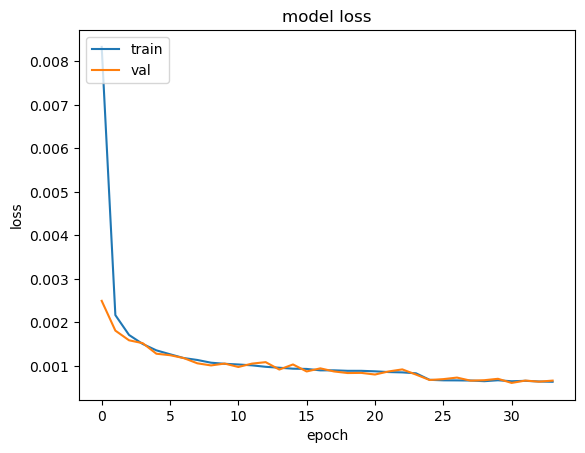

In [287]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [315]:
final_model.save('final_autoencoder.keras')

In [316]:
reconstructed_model = keras.models.load_model(
    "final_autoencoder.keras",
    custom_objects={"DenseTranspose": DenseTranspose},
)

# Final model Evaluation

We will begin by reconstructing `X_thresh_transformed`, the validation set created at the start of the project. Next, we'll determine an optimal threshold using the reconstruction errors on this validation set. This threshold will later be applied to `X_test_transformed` to evaluate performance.

The key idea behind using a threshold for classification is this:

-    If the reconstruction error is lower than the threshold, the sample is classified as genuine.
-    If the reconstruction error is higher than the threshold, the sample is classified as anomalous.

This approach works because the model was trained exclusively on genuine samples, so it will be harder to reconstruct anomalous unseen data, this results in a greater reconstruction error.

In [290]:
def calculate_reconstruction_errors(original_data, data_reconstructed):
    reconstruction_errors = np.mean(np.abs(original_data - data_reconstructed), axis=1)
    return reconstruction_errors

In [291]:
thresh_val_recon = reconstructed_model.predict(X_thresh_transformed, verbose=0)
reconstruction_errors = calculate_reconstruction_errors(X_thresh_transformed, thresh_val_recon)

The next step is to determine the optimal threshold that separates genuine and anomalous data. To do this, we evaluate performance metrics across a range of possible thresholds. We generate this range using numpy’s `linspace()` function, which creates an array of `n` values evenly spaced between two endpoints. In this case, we set the endpoints as the minimum and maximum of `reconstruction_errors`.


In [293]:
thresholds, step = np.linspace(reconstruction_errors.min(), reconstruction_errors.max(), 10000, retstep = True)
print(f'Step is : {step}')

Step is : 0.00018628749251708933


Step is the distance between each element in `thresholds` array.

---
## **Optimal threshold tuning**
Two different approaches are used, based on different metrics:

### **F1 Score-Based Approach: Balancing Precision and Recall**

The first approach seeks a balance between precision and recall by maximizing the **F1 score**.

#### **Precision**
Precision measures the accuracy of the anomaly predictions and is given by:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

A high precision value indicates that most of the detected anomalies are indeed true anomalies.

#### **Recall**
Recall measures how many of the actual anomalies are correctly identified:

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

A high recall value ensures that the model successfully detects most anomalies.

#### **F1 Score**
The **F1 score** is the harmonic mean of precision and recall, calculated as:

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Maximizing the **F1 score** ensures that the model maintains a good balance between **minimizing false positives** (high precision) and **minimizing false negatives** (high recall). This is particularly useful when **false positives and false negatives are equally costly**.


### **F2 Score-Based Approach: Prioritizing Recall**

In some scenarios, missing an anomaly (false negative) is more costly than mistakenly flagging a normal instance as an anomaly (false positive). The **F2 score** is a variation of the F1 score that places more emphasis on **recall** than on precision. This makes it a better choice when detecting anomalies is more critical than avoiding false alarms.

The **F2 score** formula is:

$$
F2 = \frac{(1 + 2^2) \times \text{Precision} \times \text{Recall}}{2^2 \times \text{Precision} + \text{Recall}}
$$

The **factor 2** in the formula gives recall **four times** more weight than precision. This ensures that the model is tuned to **catch more anomalies**, even at the cost of increasing false positives.

---


In [294]:
def find_metrics(thresholds):
    metrics_dict = {
        'thresh' : thresholds,
        'precision' : [],
        'recall' : [],
        'F1' : [],
        'F2' : []
    }
    for threshold in thresholds:
        prediction_array = (reconstruction_errors > threshold).astype(np.int32)
        metrics_dict['precision'].append(precision_score(y_thresh, prediction_array, zero_division = 0))
        metrics_dict['recall'].append(recall_score(y_thresh, prediction_array, zero_division = 0))
        metrics_dict['F1'].append(f1_score(y_thresh, prediction_array))
        metrics_dict['F2'].append(fbeta_score(y_thresh, prediction_array, beta = 2, average = 'binary'))
    return metrics_dict

In [295]:
metrics_dict = find_metrics(thresholds)
recall = metrics_dict['recall']
precision = metrics_dict['precision']
f1 = metrics_dict['F1']
f2 = metrics_dict['F2']

The `find_metrics` function calculates precision, recall, F1 and F2 scores for different threshold values. It iterates through each threshold, generates a prediction array, and compares it to the true labels of the validation set to compute the corresponding metrics. Final results are stored into a dictionary.

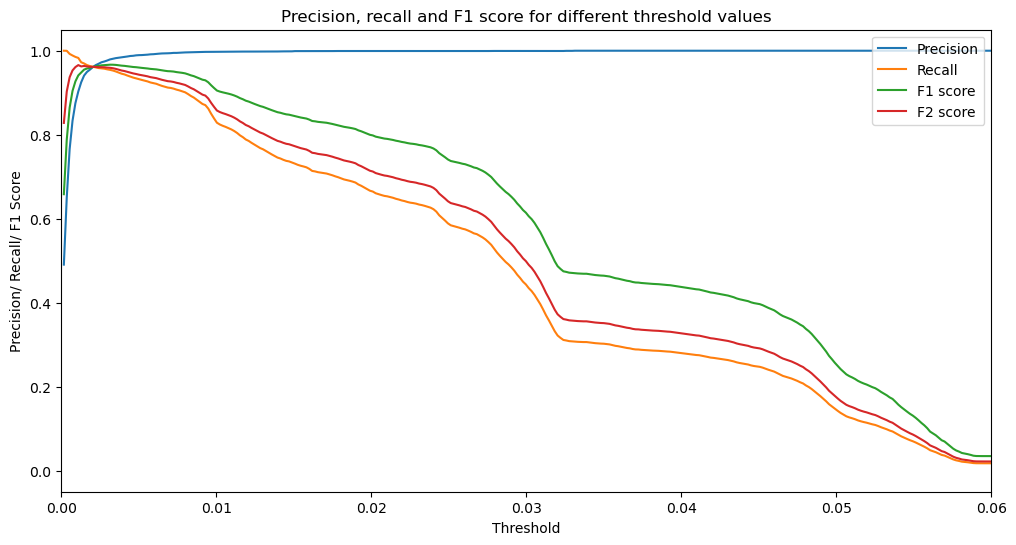

In [296]:
plt.figure(figsize = (12, 6))
plt.plot(thresholds, precision, label = "Precision", linewidth = 1.5)
plt.plot(thresholds, recall, label ="Recall", linewidth = 1.5)
plt.plot(thresholds, f1, label = "F1 score", linewidth = 1.5)
plt.plot(thresholds, f2, label = "F2 score", linewidth = 1.5)

plt.xlim(0, 0.06)
plt.xlabel('Threshold')
plt.ylabel('Precision/ Recall/ F1 Score')
plt.title('Precision, recall and F1 score for different threshold values')
plt.legend(loc = 'upper right')



To find the best thresholds based on the F1 and F2 scores, we simply select the threshold corresponding to the maximum values.


In [297]:
best_f2_idx = np.argmax(f2)
best_f2_threshold = thresholds[best_f2_idx]
print(best_f2_threshold)

0.001090250905667174


In [298]:
best_f1_idx = np.argmax(f1)
best_f1_threshold = thresholds[best_f1_idx]
print(best_f1_threshold)

0.0031394133233551566


Let's now visualize the thresholds, using the previous plot.

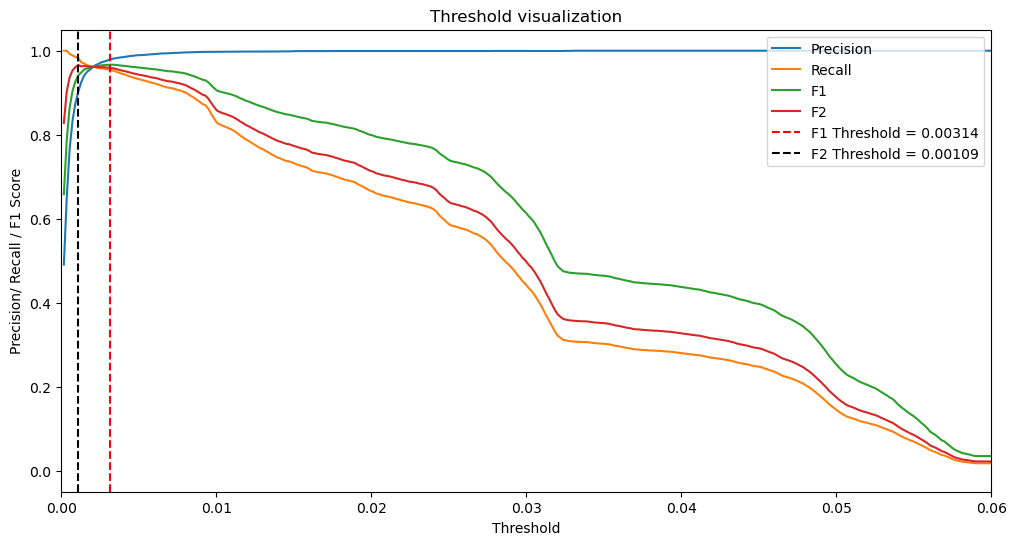

In [299]:
plt.figure(figsize = (12, 6))
plt.plot(thresholds, precision, label = "Precision", linewidth = 1.5)
plt.plot(thresholds, recall, label ="Recall", linewidth = 1.5)
plt.plot(thresholds, f1, label = "F1", linewidth = 1.5)
plt.plot(thresholds, f2, label = "F2", linewidth = 1.5)
plt.axvline(best_f1_threshold, color = 'red', ls = '--', label = 'F1 Threshold = %0.5f' % (best_f1_threshold))
plt.axvline(best_f2_threshold, color = 'black', ls = '--', label = 'F2 Threshold = %0.5f' % (best_f2_threshold))

plt.xlim(0, 0.06)
plt.xlabel('Threshold')
plt.ylabel('Precision/ Recall / F1 Score')
plt.title('Threshold visualization')
plt.legend(loc = 'upper right')

As expected, the F2 threshold prioritizes recall over precision, resulting in higher recall but lower precision. In contrast, the F1 threshold balances the two, leading to lower recall but higher precision.

## Evaluation of the model performances on Test Set

After the thresholds are found, it's time to evaluate their performances on the test set, the unseen data that simulates 'real world data'. First of all we reconstruct the test set and calculate the reconstruction error for each sample, storing it into an array.

In [300]:
test_set_reconstructed = reconstructed_model.predict(X_test_transformed, verbose=0)

In [301]:
test_reconstruction_errors = calculate_reconstruction_errors(X_test_transformed, test_set_reconstructed)

As before, we create a DataFrame to visualize how effectively the thresholds separate the two classes, but this time in the test set.

In [302]:
recons_df_test = pd.DataFrame({
    'error': test_reconstruction_errors,
    'y_true': y_test
}).reset_index(drop=True)

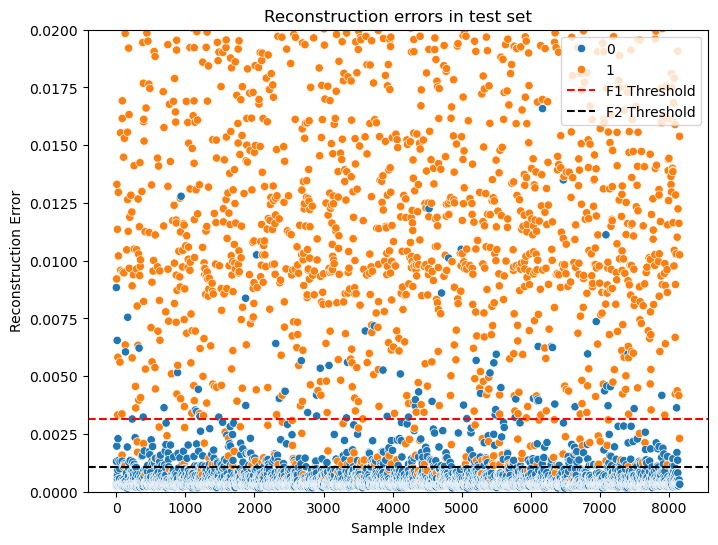

In [303]:
temp = recons_df_test.sample(frac=0.3, random_state=42).reset_index(drop=True)

plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')

plt.axhline(y=best_f1_threshold, color='r', linestyle='dashed', label='F1 Threshold')
plt.axhline(y=best_f2_threshold, color='black', linestyle='dashed', label='F2 Threshold')

plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction errors in test set')
plt.ylim(0, 0.02)
plt.legend()
plt.show()

The threshold optimized for the F1 score provides a balanced distinction between anomalies and genuine data. In contrast, the threshold based on F2 score is highly effective at detecting anomalies; however, it tends to classify a great number of genuine samples as anomalies.

In [304]:
final_prediction_f1 = test_reconstruction_errors > best_f1_threshold
final_prediction_f2 = test_reconstruction_errors > best_f2_threshold

In [305]:
report_f1 = classification_report(y_test, final_prediction_f1, digits=4)
report_f2 = classification_report(y_test, final_prediction_f2, digits=4)

print("Classification Report - F1 Based")
print(report_f1)
print("-------------------------------------------------------------------------------------")
print("Classification Report - F2 Based")
print(report_f2)

Classification Report - F1 Based
              precision    recall  f1-score   support

           0     0.9536    0.9820    0.9676     13469
           1     0.9818    0.9531    0.9672     13726

    accuracy                         0.9674     27195
   macro avg     0.9677    0.9676    0.9674     27195
weighted avg     0.9678    0.9674    0.9674     27195

-------------------------------------------------------------------------------------
Classification Report - F2 Based
              precision    recall  f1-score   support

           0     0.9792    0.9054    0.9409     13469
           1     0.9136    0.9811    0.9461     13726

    accuracy                         0.9436     27195
   macro avg     0.9464    0.9433    0.9435     27195
weighted avg     0.9461    0.9436    0.9435     27195



### Comparison of F1-Based and F2-Based Classification Approaches

The F1-based approach provides a balanced trade-off between precision and recall, ensuring that both metrics contribute equally to the final score. This results in high precision and recall for both classes, leading to an overall accuracy of **96.74%**.

On the other hand, the F2-based approach prioritizes recall over precision, making it more sensitive to correctly identifying positive instances. While this increases recall (**98.11%** for class 1), it comes at the cost of lower precision compared to the F1-based model. The overall accuracy in this case is slightly lower at **94.36%**.

---

Let's now see the confusion matrixes


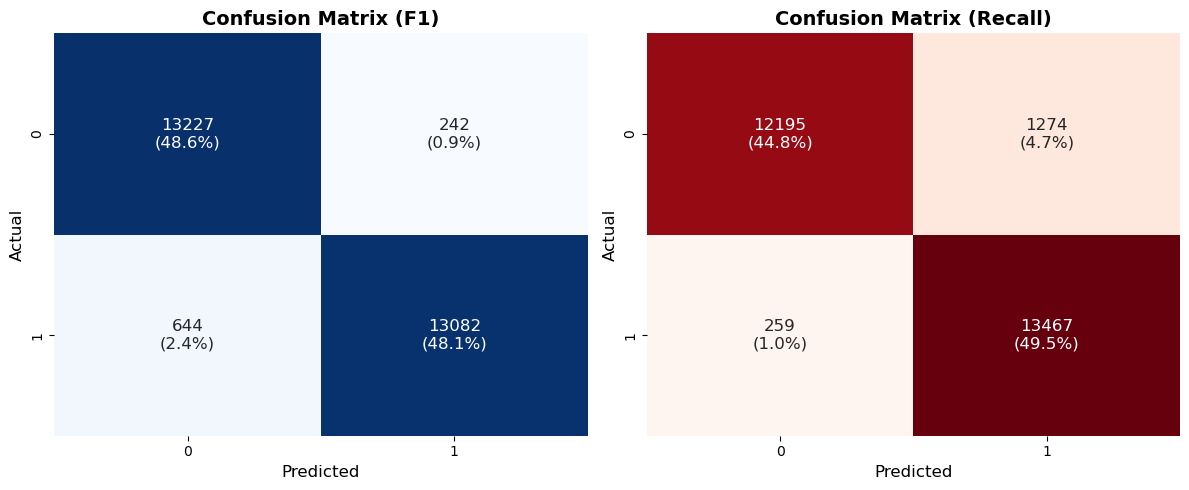

In [312]:
cm1 = confusion_matrix(y_test, final_prediction_f1)
cm2 = confusion_matrix(y_test, final_prediction_f2)

def create_annotations(cm):
    cm_percent = cm / cm.sum() * 100
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
    return annot

annot1 = create_annotations(cm1)
annot2 = create_annotations(cm2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm1, annot=annot1, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 12}, ax=axes[0])
axes[0].set_title('Confusion Matrix (F1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

sns.heatmap(cm2, annot=annot2, fmt='', cmap='Reds', cbar=False, annot_kws={"size": 12}, ax=axes[1])
axes[1].set_title('Confusion Matrix (Recall)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

With the F1-based threshold, the model achieves strong overall performance, resulting in only 644 false negatives and 242 false positives. This balance ensures both high recall and precision for each class.

However, when prioritizing recall, the number of false negatives is reduced, improving the model’s ability to detect anomalies. However, this comes at the cost of a great increase in false positives, leading to more false alarms.

Ultimately, the model demonstrates good anomaly detection capabilities. The choice of the optimal threshold depends on business needs, whether minimizing missed anomalies (favoring recall) or reducing false alarms (favoring precision) is more critical for the given application.


### Evaluation on Unseen Anomalies

As a final step, we will evaluate how the model performs at detecting the remaining unseen anomalies using the two different thresholds.

In [307]:
anomalies_transformed = pipe.transform(remaining_anomalies_X)

In [308]:
anomalies_recons = reconstructed_model.predict(anomalies_transformed, verbose=0)
reconstruction_errors = calculate_reconstruction_errors(anomalies_transformed, anomalies_recons)

In [309]:
predictions_f1 = (reconstruction_errors > best_f1_threshold).astype(int)
predictions_f2 = (reconstruction_errors > best_f2_threshold).astype(int)

In [310]:
detected_f1 = sum(predictions_f1)
detected_f2 = sum(predictions_f2)

In [311]:
print(f"Anomalies Detected with F1-based Threshold: {detected_f1}/{len(remaining_anomalies_y)}")
print(f"Anomalies Detected with Recall-based Threshold: {detected_f2}/{len(remaining_anomalies_y)}")

Anomalies Detected with F1-based Threshold: 32911/34523
Anomalies Detected with Recall-based Threshold: 33888/34523
